## 3.2 autograd

用Tensor训练网络很方便，但从上一小节最后的线性回归例子来看，反向传播过程需要手动实现。这对于像线性回归等较为简单的模型来说，还可以应付，但实际使用中经常出现非常复杂的网络结构，此时如果手动实现反向传播，不仅费时费力，而且容易出错，难以检查。torch.autograd就是为方便用户使用，而专门开发的一套自动求导引擎，它能够根据输入和前向传播过程自动构建计算图，并执行反向传播。

计算图(Computation Graph)是现代深度学习框架如PyTorch和TensorFlow等的核心，其为高效自动求导算法——反向传播(Back Propogation)提供了理论支持，了解计算图在实际写程序过程中会有极大的帮助。本节将涉及一些基础的计算图知识，但并不要求读者事先对此有深入的了解。关于计算图的基础知识推荐阅读Christopher Olah的文章[^1]。

[^1]: http://colah.github.io/posts/2015-08-Backprop/


### 3.2.1 Variable
PyTorch在autograd模块中实现了计算图的相关功能，autograd中的核心数据结构是Variable。Variable封装了tensor，并记录对tensor的操作记录用来构建计算图。Variable的数据结构如图3-2所示，主要包含三个属性：

- `data`：保存variable所包含的tensor
- `grad`：保存`data`对应的梯度，`grad`也是variable，而不是tensor，它与`data`形状一致。 
- `grad_fn`： 指向一个`Function`，记录tensor的操作历史，即它是什么操作的输出，用来构建计算图。如果某一个变量是由用户创建，则它为叶子节点，对应的grad_fn等于None。


![图3-2:Variable数据结构](imgs/autograd_Variable.png)

Variable的构造函数需要传入tensor，同时有两个可选参数：
- `requires_grad (bool)`：是否需要对该variable进行求导
- `volatile (bool)`：意为”挥发“，设置为True，则构建在该variable之上的图都不会求导，专为推理阶段设计

Variable提供了大部分tensor支持的函数，但其不支持部分`inplace`函数，因这些函数会修改tensor自身，而在反向传播中，variable需要缓存原来的tensor来计算反向传播梯度。如果想要计算各个Variable的梯度，只需调用根节点variable的`backward`方法，autograd会自动沿着计算图反向传播，计算每一个叶子节点的梯度。

`variable.backward(grad_variables=None, retain_graph=None, create_graph=None)`主要有如下参数：

- grad_variables：形状与variable一致，对于`y.backward()`，grad_variables相当于链式法则${dz \over dx}={dz \over dy} \times {dy \over dx}$中的$\textbf {dz} \over \textbf {dy}$。grad_variables也可以是tensor或序列。
- retain_graph：反向传播需要缓存一些中间结果，反向传播之后，这些缓存就被清空，可通过指定这个参数不清空缓存，用来多次反向传播。
- create_graph：对反向传播过程再次构建计算图，可通过`backward of backward`实现求高阶导数。

上述描述可能比较抽象，如果没有看懂，不用着急，会在本节后半部分详细介绍，下面先看几个例子。

In [1]:
from __future__ import print_function
import torch as t
from torch.autograd import Variable as V

In [2]:
help(V)

Help on class Variable in module torch.autograd.variable:

class Variable(torch._C._LegacyVariableBase)
 |  Method resolution order:
 |      Variable
 |      torch._C._LegacyVariableBase
 |      builtins.object
 |  
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from torch._C._LegacyVariableBase:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.



In [3]:
# 从tensor中创建variable，指定需要求导
a = V(t.ones(3,4), requires_grad = True) 
a

tensor([[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.]])

In [4]:
# b = V(t.zeros(3,4), requires_grad=True)
b = V(t.zeros(3,4))  # Variable requires_grad is False by default
b

tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]])

In [5]:
# 函数的使用与tensor一致
# 也可写成c = a + b
c = a.add(b)
c

tensor([[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.]])

In [6]:
d = c.sum()
d.backward() # 反向传播

In [7]:
# 注意二者的区别
# 前者在取data后变为tensor，而后从tensor计算sum得到float
# 后者计算sum后仍然是Variable
c.data.sum(), c.sum()

(tensor(12.), tensor(12.))

In [8]:
a.grad

tensor([[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.]])

In [9]:
# 此处虽然没有指定c需要求导，但c依赖于a，而a需要求导，
# 因此c的requires_grad属性会自动设为True
a.requires_grad, b.requires_grad, c.requires_grad

(True, False, True)

In [10]:
# 由用户创建的variable属于叶子节点，对应的grad_fn是None
a.is_leaf, b.is_leaf, c.is_leaf

(True, True, False)

In [11]:
# c.grad是None, 因c不是叶子节点，它的梯度是用来计算a的梯度
# 所以虽然c.requires_grad = True,但其梯度计算完之后即被释放
print(c.grad is None)
print(a.grad is None)

True
False


计算下面这个函数的导函数：
$$
y = x^2\bullet e^x
$$
它的导函数是：
$$
{dy \over dx} = 2x\bullet e^x + x^2 \bullet e^x
$$
来看看autograd的计算结果与手动求导计算结果的误差。

In [12]:
def f(x):
    '''计算y'''
    y = x**2 * t.exp(x)
    return y

def gradf(x):
    '''手动求导函数'''
    dx = 2*x*t.exp(x) + x**2*t.exp(x)
    return dx

In [13]:
x = V(t.randn(3,4), requires_grad = True)
y = f(x)
y

tensor([[ 0.4915,  0.0509,  2.3108,  1.2717],
        [ 0.3642,  0.7354,  0.4723,  0.1075],
        [ 0.2504,  0.1563,  0.2090,  0.2763]])

In [14]:
# 从y进行反向传播的时候y的导数应该都是 1
y.backward(t.ones(y.size())) # grad_variables形状与y一致
x.grad

tensor([[-0.1905, -0.3460,  7.1919,  4.5831],
        [-0.3715,  3.0818, -0.2278, -0.4292],
        [-0.4493, -0.4563, -0.4600,  1.5766]])

In [15]:
# autograd的计算结果与利用公式手动计算的结果一致
gradf(x) 

tensor([[-0.1905, -0.3460,  7.1919,  4.5831],
        [-0.3715,  3.0818, -0.2278, -0.4292],
        [-0.4493, -0.4563, -0.4600,  1.5766]])

### 3.2.2 计算图

PyTorch中`autograd`的底层采用了计算图，计算图是一种特殊的有向无环图（DAG），用于记录算子与变量之间的关系。一般用矩形表示算子，椭圆形表示变量。如表达式$ \textbf {z = wx + b}$可分解为$\textbf{y = wx}$和$\textbf{z = y + b}$，其计算图如图3-3所示，图中`MUL`，`ADD`都是算子，$\textbf{w}$，$\textbf{x}$，$\textbf{b}$即变量。

![图3-3:computation graph](imgs/com_graph.svg)

如上有向无环图中，$\textbf{X}$和$\textbf{b}$是叶子节点（leaf node），这些节点通常由用户自己创建，不依赖于其他变量。$\textbf{z}$称为根节点，是计算图的最终目标。利用链式法则很容易求得各个叶子节点的梯度。
$${\partial z \over \partial b} = 1,\space {\partial z \over \partial y} = 1\\
{\partial y \over \partial w }= x,{\partial y \over \partial x}= w\\
{\partial z \over \partial x}= {\partial z \over \partial y} {\partial y \over \partial x}=1 * w\\
{\partial z \over \partial w}= {\partial z \over \partial y} {\partial y \over \partial w}=1 * x\\
$$
而有了计算图，上述链式求导即可利用计算图的反向传播自动完成，其过程如图3-4所示。

![图3-4：计算图的反向传播](imgs/com_graph_backward.svg)


在PyTorch实现中，autograd会随着用户的操作，记录生成当前variable的所有操作，并由此建立一个有向无环图。用户每进行一个操作，相应的计算图就会发生改变。更底层的实现中，图中记录了操作`Function`，每一个变量在图中的位置可通过其`grad_fn`属性在图中的位置推测得到。在反向传播过程中，autograd沿着这个图从当前变量（根节点$\textbf{z}$）溯源，可以利用链式求导法则计算所有叶子节点的梯度。每一个前向传播操作的函数都有与之对应的反向传播函数用来计算输入的各个variable的梯度，这些函数的函数名通常以`Backward`结尾。下面结合代码学习autograd的实现细节。

In [16]:
x = V(t.ones(1))
b = V(t.rand(1), requires_grad = True)
w = V(t.rand(1), requires_grad = True)
y = w * x # 等价于y=w.mul(x)
z = y + b # 等价于z=y.add(b)

In [17]:
x.requires_grad, b.requires_grad, w.requires_grad

(False, True, True)

In [18]:
# 虽然未指定y.requires_grad为True，但由于y依赖于需要求导的w
# 故而y.requires_grad为True
print(y.requires_grad)
print(z.requires_grad)

True
True


In [19]:
x.is_leaf, w.is_leaf, b.is_leaf

(True, True, True)

In [20]:
y.is_leaf, z.is_leaf

(False, False)

In [21]:
# grad_fn可以查看这个variable的反向传播函数，
# z是add函数的输出，所以它的反向传播函数是AddBackward
z.grad_fn 

In [24]:
# next_functions保存grad_fn的输入，是一个tuple，tuple的元素也是Function
# 第一个是y，它是乘法(mul)的输出，所以对应的反向传播函数y.grad_fn是MulBackward
# 第二个是b，它是叶子节点，由用户创建，grad_fn为None，但是有
z.grad_fn.next_functions 

((<MulBackward1 at 0x7f4e148a86a0>, 0),
 (<AccumulateGrad at 0x7f4e148a8dd8>, 0))

In [25]:
# variable的grad_fn对应着和图中的function相对应
z.grad_fn.next_functions[0][0] == y.grad_fn

True

In [26]:
# 第一个是w，叶子节点，需要求导，梯度是累加的
# 第二个是x，叶子节点，不需要求导，所以为None
y.grad_fn.next_functions

((<AccumulateGrad at 0x7f4e148f7f28>, 0), (None, 0))

In [27]:
# 叶子节点的grad_fn是None
w.grad_fn,x.grad_fn

(None, None)

计算w的梯度的时候，需要用到x的数值(${\partial y\over \partial w} = x $)，这些数值在前向过程中会保存成buffer，在计算完梯度之后会自动清空。为了能够多次反向传播需要指定`retain_graph`来保留这些buffer。

In [28]:
# 使用retain_graph来保存buffer
z.backward(retain_graph=True)
w.grad

tensor([ 1.])

In [29]:
# 多次反向传播，梯度累加，这也就是w中AccumulateGrad标识的含义
z.backward()
w.grad

tensor([ 2.])

PyTorch使用的是动态图，它的计算图在每次前向传播时都是从头开始构建，所以它能够使用Python控制语句（如for、if等）根据需求创建计算图。这点在自然语言处理领域中很有用，它意味着你不需要事先构建所有可能用到的图的路径，图在运行时才构建。

In [30]:
def abs(x):
    if x.data[0]>0: return x
    else: return -x
x = V(t.ones(1),requires_grad=True)
y = abs(x)
y.backward()
x.grad

tensor([ 1.])

In [31]:
x = V(-1*t.ones(1),requires_grad=True)
y = abs(x)
y.backward()
print(x.grad)

tensor([-1.])


In [32]:
def f(x):
    result = 1
    for ii in x:
        if ii.data[0]>0: result=ii*result
    return result
x = V(t.arange(-2,4),requires_grad=True)
y = f(x) # y = x[3]*x[4]*x[5]
y.backward()
x.grad

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  after removing the cwd from sys.path.


tensor([ 0.,  0.,  0.,  6.,  3.,  2.])

变量的`requires_grad`属性默认为False，如果某一个节点requires_grad被设置为True，那么所有依赖它的节点`requires_grad`都是True。这其实很好理解，对于$ \textbf{x}\to \textbf{y} \to \textbf{z}$，x.requires_grad = True，当需要计算$\partial z \over \partial x$时，根据链式法则，$\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} \frac{\partial y}{\partial x}$，自然也需要求$ \frac{\partial z}{\partial y}$，所以y.requires_grad会被自动标为True. 

`volatile=True`是另外一个很重要的标识，它能够将所有依赖于它的节点全部都设为`volatile=True`，其优先级比`requires_grad=True`高。`volatile=True`的节点不会求导，即使`requires_grad=True`，也无法进行反向传播。对于不需要反向传播的情景（如inference，即测试推理时），该参数可实现一定程度的速度提升，并节省约一半显存，因其不需要分配空间计算梯度。

In [33]:
x = V(t.ones(1))
w = V(t.rand(1), requires_grad=True)
y = x * w
# y依赖于w，而w.requires_grad = True
x.requires_grad, w.requires_grad, y.requires_grad

(False, True, True)

In [34]:
x = V(t.ones(1), volatile=True)
w = V(t.rand(1), requires_grad = True)
y = x * w
# y依赖于w和x，但x.volatile = True，w.requires_grad = True
x.requires_grad, w.requires_grad, y.requires_grad

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """Entry point for launching an IPython kernel.


(False, True, True)

In [32]:
x.volatile, w.volatile, y.volatile

(True, False, True)

在反向传播过程中非叶子节点的导数计算完之后即被清空。若想查看这些变量的梯度，有两种方法：
- 使用autograd.grad函数
- 使用hook

`autograd.grad`和`hook`方法都是很强大的工具，更详细的用法参考官方api文档，这里举例说明基础的使用。推荐使用`hook`方法，但是在实际使用中应尽量避免修改grad的值。

In [39]:
x = V(t.ones(3), requires_grad=True)
w = V(t.rand(3), requires_grad=True)
y = x * w
# y依赖于w，而w.requires_grad = True
z = y.sum()
x.requires_grad, w.requires_grad, y.requires_grad

(True, True, True)

In [40]:
# 非叶子节点grad计算完之后自动清空，y.grad是None
z.backward()
(x.grad, w.grad, y.grad)

(tensor([ 0.5884,  0.3641,  0.7060]), tensor([ 1.,  1.,  1.]), None)

In [46]:
# 第一种方法：使用grad获取中间变量的梯度
x = V(t.ones(3), requires_grad=True)
w = V(t.rand(3), requires_grad=True)
y = x * w
z = y.sum()
# z对y的梯度，隐式调用backward()
t.autograd.grad(z, y), t.autograd.grad(z, w)

((tensor([ 1.,  1.,  1.]),), (tensor([ 1.,  1.,  1.]),))

In [45]:
# 第二种方法：使用hook
# hook是一个函数，输入是梯度，不应该有返回值
def variable_hook(grad):
    print('y的梯度： \r\n',grad)

x = V(t.ones(3), requires_grad=True)
w = V(t.rand(3), requires_grad=True)
y = x * w
# 注册hook
hook_handle = y.register_hook(variable_hook)
z = y.sum()
z.backward()

# 除非你每次都要用hook，否则用完之后记得移除hook
hook_handle.remove()

y的梯度： 
 tensor([ 1.,  1.,  1.])


最后再来看看variable中grad属性和backward函数`grad_variables`参数的含义，这里直接下结论：

- variable $\textbf{x}$的梯度是目标函数${f(x)} $对$\textbf{x}$的梯度，$\frac{df(x)}{dx} = (\frac {df(x)}{dx_0},\frac {df(x)}{dx_1},...,\frac {df(x)}{dx_N})$，形状和$\textbf{x}$一致。
- 对于y.backward(grad_variables)中的grad_variables相当于链式求导法则中的$\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} \frac{\partial y}{\partial x}$中的$\frac{\partial z}{\partial y}$。z是目标函数，一般是一个标量，故而$\frac{\partial z}{\partial y}$的形状与variable $\textbf{y}$的形状一致。`z.backward()`在一定程度上等价于y.backward(grad_y)。`z.backward()`省略了grad_variables参数，是因为$z$是一个标量，而$\frac{\partial z}{\partial z} = 1$

In [47]:
x = V(t.arange(0,3), requires_grad=True)
y = x**2 + x*2
z = y.sum()
z.backward() # 从z开始反向传播
x.grad

tensor([ 2.,  4.,  6.])

In [50]:
x = V(t.arange(0,3), requires_grad=True)
y = x**2 + x*2
z = y.sum()
y_grad_variables = V(t.Tensor([1,1,1])) # dz/dy
y.backward(y_grad_variables) #从y开始反向传播
x.grad

tensor([ 2.,  4.,  6.])

可以看出来上述两个方法得到的x的梯度是一致的

另外值得注意的是，只有对variable的操作才能使用autograd，如果对variable的data直接进行操作，将无法使用反向传播。除了对参数初始化，一般我们不会修改variable.data的值。

在PyTorch中计算图的特点可总结如下：

- autograd根据用户对variable的操作构建其计算图。对变量的操作抽象为`Function`。
- 对于那些不是任何函数(Function)的输出，由用户创建的节点称为叶子节点，叶子节点的`grad_fn`为None。叶子节点中需要求导的variable，具有`AccumulateGrad`标识，因其梯度是累加的。
- variable默认是不需要求导的，即`requires_grad`属性默认为False，如果某一个节点requires_grad被设置为True，那么所有依赖它的节点`requires_grad`都为True。
- variable的`volatile`属性默认为False，如果某一个variable的`volatile`属性被设为True，那么所有依赖它的节点`volatile`属性都为True。volatile属性为True的节点不会求导，volatile的优先级比`requires_grad`高。
- 多次反向传播时，梯度是累加的。反向传播的中间缓存会被清空，为进行多次反向传播需指定`retain_graph`=True来保存这些缓存。
- 非叶子节点的梯度计算完之后即被清空，可以使用`autograd.grad`或`hook`技术获取非叶子节点的值。
- variable的grad与data形状一致，应避免直接修改variable.data，因为对data的直接操作无法利用autograd进行反向传播
- 反向传播函数`backward`的参数`grad_variables`可以看成链式求导的中间结果，如果是标量，可以省略，默认为1
- PyTorch采用动态图设计，可以很方便地查看中间层的输出，动态的设计计算图结构。

### 3.2.3 扩展autograd


目前绝大多数函数都可以使用`autograd`实现反向求导，但如果需要自己写一个复杂的函数，不支持自动反向求导怎么办? 写一个`Function`，实现它的前向传播和反向传播代码，`Function`对应于计算图中的矩形， 它接收参数，计算并返回结果。下面给出一个例子。

```python

class Mul(Function):
                                                            
    @staticmethod
    def forward(ctx, w, x, b, x_requires_grad = True):
        ctx.x_requires_grad = x_requires_grad
        ctx.save_for_backward(w,x)
        output = w * x + b
        return output
        
    @staticmethod
    def backward(ctx, grad_output):
        w,x = ctx.saved_variables
        grad_w = grad_output * x
        if ctx.x_requires_grad:
            grad_x = grad_output * w
        else:
            grad_x = None
        grad_b = grad_output * 1
        return grad_w, grad_x, grad_b, None
```

分析如下：

- 自定义的Function需要继承autograd.Function，没有构造函数`__init__`，forward和backward函数都是静态方法
- forward函数的输入和输出都是Tensor，backward函数的输入和输出都是Variable
- backward函数的输出和forward函数的输入一一对应，backward函数的输入和forward函数的输出一一对应
- backward函数的grad_output参数即t.autograd.backward中的`grad_variables`
- 如果某一个输入不需要求导，直接返回None，如forward中的输入参数x_requires_grad显然无法对它求导，直接返回None即可
- 反向传播可能需要利用前向传播的某些中间结果，需要进行保存，否则前向传播结束后这些对象即被释放

Function的使用利用Function.apply(variable)

In [51]:
from torch.autograd import Function
class MultiplyAdd(Function):
                                                            
    @staticmethod
    def forward(ctx, w, x, b):                              
        print('type in forward',type(x))
        ctx.save_for_backward(w,x)
        output = w * x + b
        return output
        
    @staticmethod
    def backward(ctx, grad_output):                         
        w,x = ctx.saved_variables
        print('type in backward',type(x))
        grad_w = grad_output * x
        grad_x = grad_output * w
        grad_b = grad_output * 1
        return grad_w, grad_x, grad_b                       

In [52]:
x = V(t.ones(1))
w = V(t.rand(1), requires_grad = True)
b = V(t.rand(1), requires_grad = True)
print('开始前向传播')
z=MultiplyAdd.apply(w, x, b)
print('开始反向传播')
z.backward()

# x不需要求导，中间过程还是会计算它的导数，但随后被清空
x.grad, w.grad, b.grad

开始前向传播type in backward
 type in forward<class 'torch.Tensor'> 
<class 'torch.Tensor'>
开始反向传播


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  del sys.path[0]


(None, tensor([ 1.]), tensor([ 1.]))

In [53]:
x = V(t.ones(1))
w = V(t.rand(1), requires_grad = True)
b = V(t.rand(1), requires_grad = True)
print('开始前向传播')
z=MultiplyAdd.apply(w,x,b)
print('开始反向传播')

# 调用MultiplyAdd.backward
# 输出grad_w, grad_x, grad_b
z.grad_fn.apply(V(t.ones(1)))

开始前向传播
type in forward <class 'torch.Tensor'>
开始反向传播
type in backward <class 'torch.Tensor'>


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  del sys.path[0]


(tensor([ 1.]), tensor([ 0.2256]), tensor([ 1.]))

之所以forward函数的输入是tensor，而backward函数的输入是variable，是为了实现高阶求导。backward函数的输入输出虽然是variable，但在实际使用时autograd.Function会将输入variable提取为tensor，并将计算结果的tensor封装成variable返回。在backward函数中，之所以也要对variable进行操作，是为了能够计算梯度的梯度（backward of backward）。下面举例说明，有关torch.autograd.grad的更详细使用请参照文档。

In [42]:
x = V(t.Tensor([5]), requires_grad=True)
y = x ** 2
grad_x = t.autograd.grad(y, x, create_graph=True)
grad_x # dy/dx = 2 * x

(Variable containing:
  10
 [torch.FloatTensor of size 1],)

In [43]:
grad_grad_x = t.autograd.grad(grad_x[0],x)
grad_grad_x # 二阶导数 d(2x)/dx = 2

(Variable containing:
  2
 [torch.FloatTensor of size 1],)

这种设计虽然能让`autograd`具有高阶求导功能，但其也限制了Tensor的使用，因autograd中反向传播的函数只能利用当前已经有的Variable操作。这个设计是在`0.2`版本新加入的，为了更好的灵活性，也为了兼容旧版本的代码，PyTorch还提供了另外一种扩展autograd的方法。PyTorch提供了一个装饰器`@once_differentiable`，能够在backward函数中自动将输入的variable提取成tensor，把计算结果的tensor自动封装成variable。有了这个特性我们就能够很方便的使用numpy/scipy中的函数，操作不再局限于variable所支持的操作。但是这种做法正如名字中所暗示的那样只能求导一次，它打断了反向传播图，不再支持高阶求导。


上面所描述的都是新式Function，还有个legacy Function，可以带有`__init__`方法，`forward`和`backwad`函数也不需要声明为`@staticmethod`，但随着版本更迭，此类Function将越来越少遇到，在此不做更多介绍。

此外在实现了自己的Function之后，还可以使用`gradcheck`函数来检测实现是否正确。`gradcheck`通过数值逼近来计算梯度，可能具有一定的误差，通过控制`eps`的大小可以控制容忍的误差。
关于这部份的内容可以参考github上开发者们的讨论[^3]。

[^3]: https://github.com/pytorch/pytorch/pull/1016

下面举例说明如何利用Function实现sigmoid Function。

In [55]:
class Sigmoid(Function):
                                                             
    @staticmethod
    def forward(ctx, x): 
        output = 1 / (1 + t.exp(-x))
        ctx.save_for_backward(output)
        return output
        
    @staticmethod
    def backward(ctx, grad_output): 
        output,  = ctx.saved_variables
        grad_x = output * (1 - output) * grad_output
        return grad_x                            

In [56]:
# 采用数值逼近方式检验计算梯度的公式对不对
test_input = V(t.randn(3,4), requires_grad=True)
t.autograd.gradcheck(Sigmoid.apply, (test_input,), eps=1e-3)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()


True

In [57]:
def f_sigmoid(x):
    y = Sigmoid.apply(x)
    y.backward(t.ones(x.size()))
    
def f_naive(x):
    y =  1/(1 + t.exp(-x))
    y.backward(t.ones(x.size()))
    
def f_th(x):
    y = t.sigmoid(x)
    y.backward(t.ones(x.size()))
    
x=V(t.randn(100, 100), requires_grad=True)
%timeit -n 100 f_sigmoid(x)
%timeit -n 100 f_naive(x)
%timeit -n 100 f_th(x)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # This is added back by InteractiveShellApp.init_path()


The slowest run took 6.33 times longer than the fastest. This could mean that an intermediate result is being cached.
748 µs ± 562 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
293 µs ± 77.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
101 µs ± 22.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


显然`f_sigmoid`要比单纯利用`autograd`加减和乘方操作实现的函数快不少，因为f_sigmoid的backward优化了反向传播的过程。另外可以看出系统实现的buildin接口(t.sigmoid)更快。

### 3.2.4 小试牛刀: 用Variable实现线性回归
在上一节中讲解了利用tensor实现线性回归，在这一小节中，将讲解如何利用autograd/Variable实现线性回归，以此感受autograd的便捷之处。

In [58]:
import torch as t
from torch.autograd import Variable as V
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display

In [59]:
# 设置随机数种子，为了在不同人电脑上运行时下面的输出一致
t.manual_seed(1000) 

def get_fake_data(batch_size=8):
    ''' 产生随机数据：y = x*2 + 3，加上了一些噪声'''
    x = t.rand(batch_size,1) * 20
    y = x * 2 + (1 + t.randn(batch_size, 1))*3
    return x, y

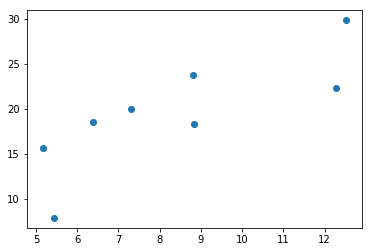

In [60]:
# 来看看产生x-y分布是什么样的
x, y = get_fake_data()
plt.scatter(x.squeeze().numpy(), y.squeeze().numpy())

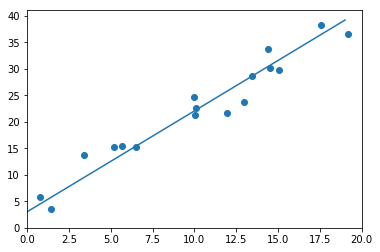

tensor(2.0407) tensor(2.9471)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [94]:
# 随机初始化参数
w = V(t.rand(1,1), requires_grad=True)
b = V(t.zeros(1,1), requires_grad=True)

lr =0.001 # 学习率

for ii in range(8000):
    x, y = get_fake_data()
    x, y = V(x), V(y)
    
    # forward：计算loss
    y_pred = x.mm(w) + b.expand_as(y)
    loss = 0.5 * (y_pred - y) ** 2
    loss = loss.sum()
    
    # backward：手动计算梯度
    loss.backward()
    
    # 更新参数
    w.data.sub_(lr * w.grad.data)
    b.data.sub_(lr * b.grad.data)
    
    # 梯度清零
    w.grad.data.zero_()
    b.grad.data.zero_()
    
    if ii%1000 ==0:
        # 画图
        display.clear_output(wait=True)
        x = t.arange(0, 20).view(-1, 1)
        y = x.mm(w.data) + b.data.expand_as(x)
        plt.plot(x.numpy(), y.numpy()) # predicted
        
        x2, y2 = get_fake_data(batch_size=20) 
        plt.scatter(x2.numpy(), y2.numpy()) # true data
        
        plt.xlim(0,20)
        plt.ylim(0,41)   
        plt.show()
        plt.pause(0.5)
        
print(w.data.squeeze()[0], b.data.squeeze()[0])

用autograd实现的线性回归最大的不同点就在于autograd不需要计算反向传播，可以自动计算微分。这点不单是在深度学习，在许多机器学习的问题中都很有用。另外需要注意的是在每次反向传播之前要记得先把梯度清零。

本章主要介绍了PyTorch中两个基础底层的数据结构：Tensor和autograd中的Variable。Tensor是一个类似Numpy数组的高效多维数值运算数据结构，有着和Numpy相类似的接口，并提供简单易用的GPU加速。Variable是autograd封装了Tensor并提供自动求导技术的，具有和Tensor几乎一样的接口。`autograd`是PyTorch的自动微分引擎，采用动态计算图技术，能够快速高效的计算导数。

In [62]:
import torch as t
from torch.autograd import Variable as V
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display

In [63]:
x, y = get_fake_data()
print(x.shape)

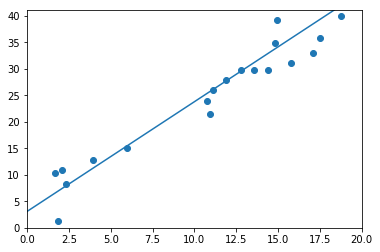

In [105]:
# 使用pytorch实现线性回归

# Steps
# 1. 定义变量

lr = 1e-3
w = V(t.rand(1,1), requires_grad=True)
b = V(t.zeros(1,1), requires_grad=True)

for i in range(10000) :
    
    x, y = get_fake_data()
    x = V(x)
    y = V(y)

    # 2. 定义计算图
    # print(x.shape, w.shape)
    y_pred = x.mm(w) + b.expand_as(y)    # mm : matrix multiplication do not broadcast.  (8,1)*(1,1) + (1,1)
    loss = (y_pred - y)**2 * 0.5
    loss = loss.sum()

    # 3. 反向传播，更新变量
    loss.backward()

    w.data.sub_(w.grad.data * lr)
    b.data.sub_(b.grad.data * lr)

    w.grad.data.zero_()
    b.grad.data.zero_()
    
    # 4. 绘图
    if i%1000 ==0:
        display.clear_output(wait=True)
        x = t.arange(0, 20).view(-1, 1)
        y = x.mm(w.data) + b.data.expand_as(x)
        plt.plot(x.numpy(), y.numpy()) # predicted
        
        x2, y2 = get_fake_data(batch_size=20) 
        plt.scatter(x2.numpy(), y2.numpy()) # true data
        
        plt.xlim(0,20)
        plt.ylim(0,41)   
        plt.show()
        plt.pause(0.5)
